# Schrodinger's Equation

## References -- move to bottom
* Atkins & Friedman (Molecular Quantum Mechanics textbook)
* Barba, Lorena A., et al. "MAE 6286 Practical Numerical Methods with Python." The George Washington University. http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about. 2014
* http://arxiv.org/pdf/0704.3240.pdf
* http://phys.au.dk/fileadmin/site_files/publikationer/phd/Thomas_Kim_Kjeldsen.pdf

Wave functions are used in quantum mechanics to describe the position of a particle at a certain time. The fundamental equation used to solve these wave functions is the Schrodinger equation. 

\begin{equation}
i\hbar\frac{\partial}{\partial t}\psi(x, t) = -\frac{\hbar^2}{2m} \frac{\partial^2}{\partial x^2}\psi(x, t)
\end{equation}

Discretized Equation:

\begin{eqnarray}
i\hbar\frac{\psi^{n+1}_i - \psi^n_i}{\Delta t} = \frac{\hbar^2}{2m} \cdot \frac{1}{2} &\left( 
\frac{\psi^{n+1}_{i+1} - 2\psi^{n+1}_i + \psi^{n+1}_{i-1}}{\Delta x^2} 
+ \frac{\psi^n_{i+1}-2\psi^n_i + \psi^n_{i-1}}{\Delta x^2}
\right)
\end{eqnarray}

In [289]:
import numpy
from scipy.linalg import solve
from scipy.interpolate import spline
from matplotlib import pyplot
from mpl_toolkits.mplot3d.axes3d import Axes3D
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [290]:
L = 10
nx = 101 #21

h = 6.62607004e-34 #[m^2*kg/s]
hbar = h/(2*numpy.pi)
#hbar=1
m = 9.10938356e-31 #[kg] - mass of electron
dx = L/(nx-1)

a = hbar/(2*m)
#print(a)


psi_i = numpy.zeros(nx, dtype = numpy.complex)
psi_i[0] = 1

sigma = 9 #0.5
dt = (dx**2)/(a*sigma)
#dt=1e-5

nt = 10
print(hbar)
print(dt)

1.0545718001391127e-34
19.19553943610804


In [291]:
def generateMatrix(N, sigma):
   
    ##We need a TRIDIAGONAL MATRIX!!

    # Set Diagonalfrom discritization
    d = 2*numpy.diag(numpy.ones(N-2)*(1+1/sigma))
       
    # Set Upper Diagonal
    ud = numpy.diag(numpy.ones(N-3)*-1j, 1)
        
    # Set Lower Diagonal
    ld = numpy.diag(numpy.ones(N-3)*-1j, -1)
        
    A = d + ud + ld
    
    return A                   

In [292]:
#This is what we know

def genRHS(psi, sigma): 
    
    x = psi[1:-1]*2*(-1-1j/sigma) + psi[:-2] + psi[2:]
    
    #Dirichlet boundary conditions
    x[0] = psi[0]
    x[-1] = psi[0]
    
    return x

In [293]:
def CrankNicolson(psi, A, nt, sigma):
    
    for t in range(nt):
        psi_n = psi.copy()
        x = genRHS(psi_n, sigma)
        
        psi_inside = solve(A, x)
        psi[1:-1] = psi_inside
        
    return psi

In [294]:
A = generateMatrix(nx, sigma)

#print(A)

In [295]:
psi = CrankNicolson(psi_i.copy(), A, nt, sigma)

print(psi)

[  1.00000000e+00 +0.00000000e+00j   4.06554293e-01 +5.95472816e-02j
   1.32327292e-01 +9.65460151e-02j  -1.02992860e-01 +6.83770426e-02j
   8.84849127e-02 -6.62159673e-02j  -5.65638535e-02 +1.26428432e-01j
  -4.33163743e-02 -1.33401285e-01j   1.17546772e-01 +5.57414292e-02j
  -1.03696850e-01 +5.10191801e-02j   1.29786356e-02 -9.75637370e-02j
   6.39048153e-02 +4.89692740e-02j  -5.71265429e-02 +2.77851532e-02j
  -1.85422304e-03 -4.84830039e-02j   3.39883557e-02 +1.17367512e-02j
  -1.59800812e-02 +2.03923583e-02j  -1.03828442e-02 -1.49201981e-02j
   1.17257713e-02 -4.14694018e-03j   8.18208236e-04 +8.26988270e-03j
  -5.39052254e-03 -6.44340120e-04j   1.07705735e-03 -3.30023861e-03j
   1.91607634e-03 +1.02988163e-03j  -8.13695908e-04 +1.06100535e-03j
  -5.62002540e-04 -5.79156194e-04j   3.84729188e-04 -2.84894496e-04j
   1.37896998e-04 +2.42974665e-04j  -1.47516314e-04 +6.33308050e-05j
  -2.72295591e-05 -8.67328447e-05j   4.96416825e-05 -1.06462414e-05j
   3.51179260e-06 +2.77652817e-05j

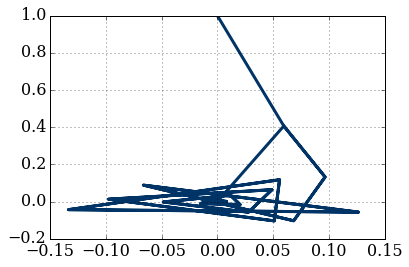

In [296]:
x = numpy.linspace(0,L,nx)

pyplot.plot(psi.imag, psi.real, color='#003366', ls='-', lw=3);
pyplot.grid(True)

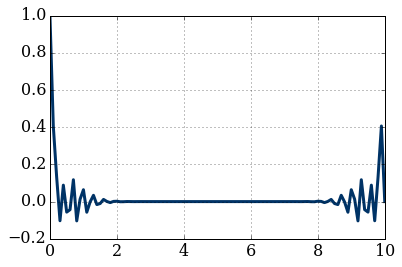

In [297]:
pyplot.plot(x, psi.real, color='#003366', ls='-', lw=3);
pyplot.grid(True)

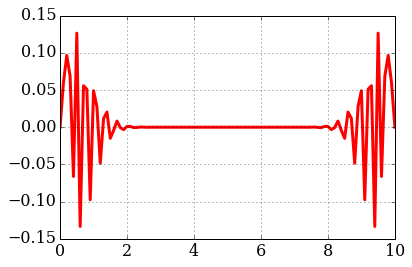

In [298]:
pyplot.plot(x, psi.imag, color='r', ls='-', lw=3);
pyplot.grid(True)

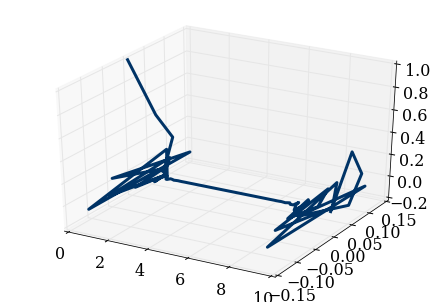

In [299]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.view_init()

ax.plot(x, psi.imag, psi.real, color = '#003366', lw =3)


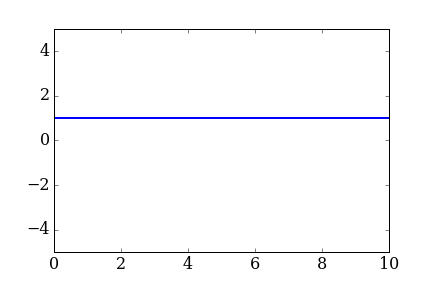
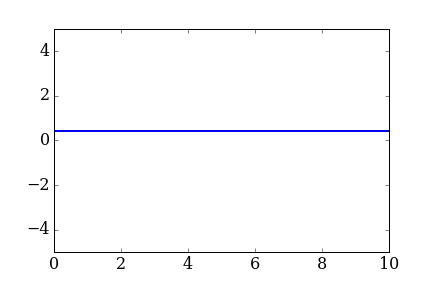
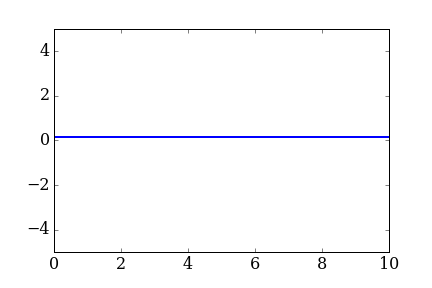
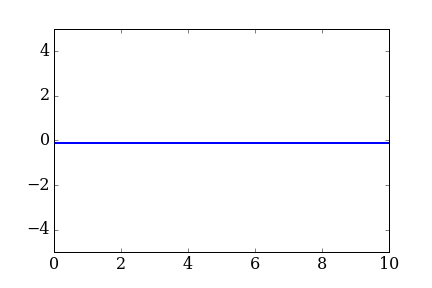
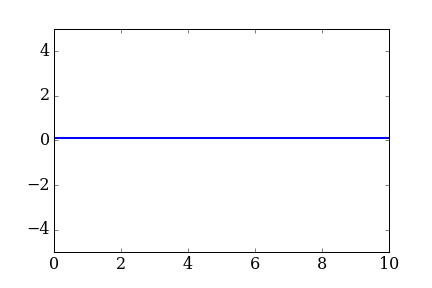
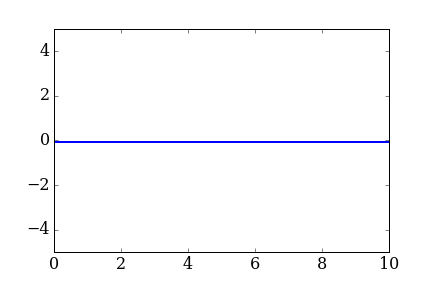
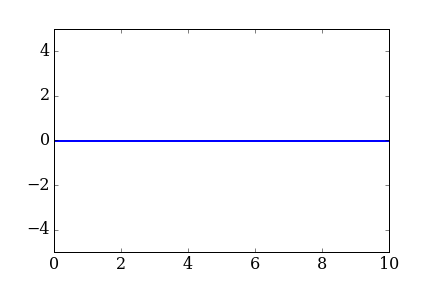
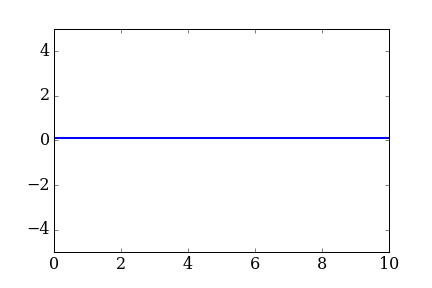
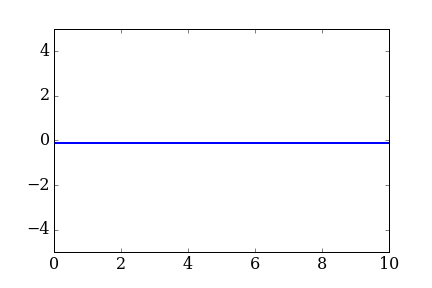
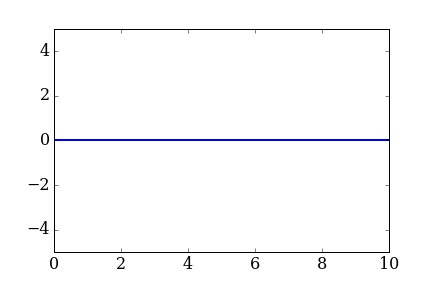
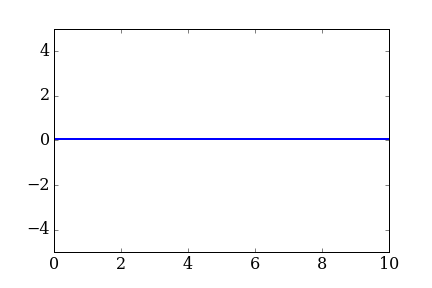
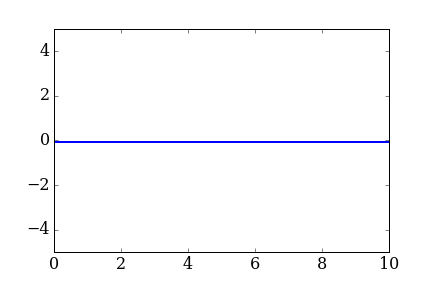
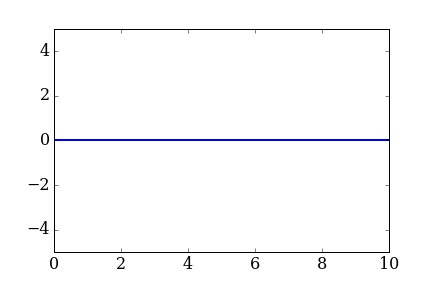
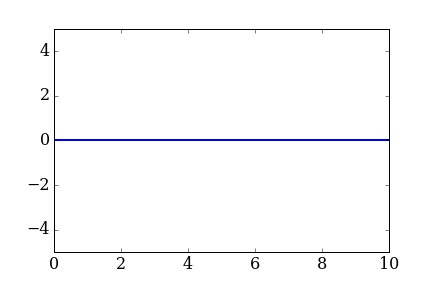
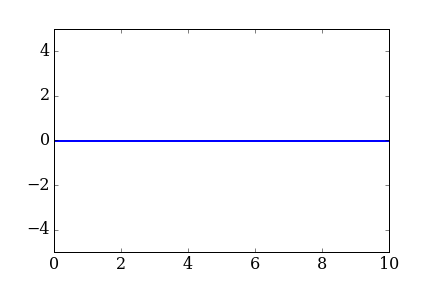
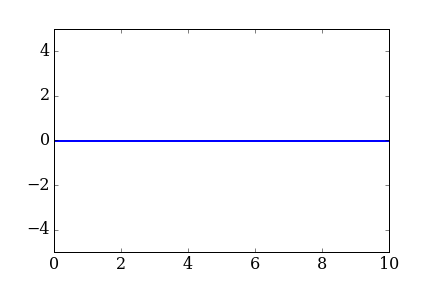
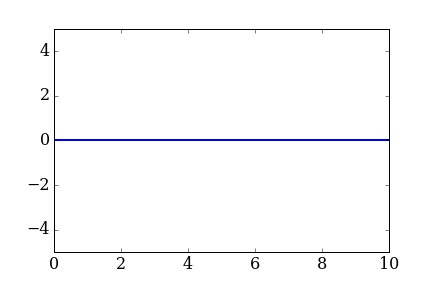
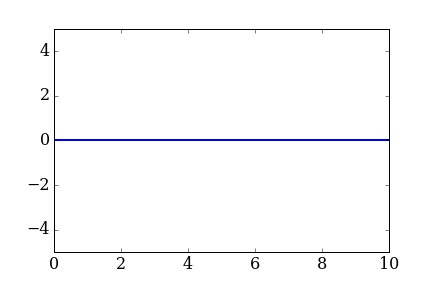
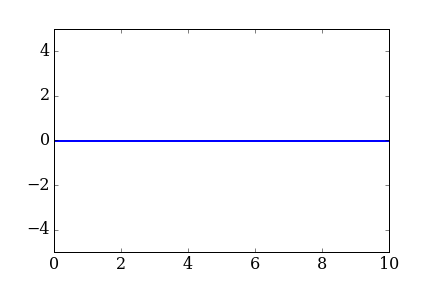
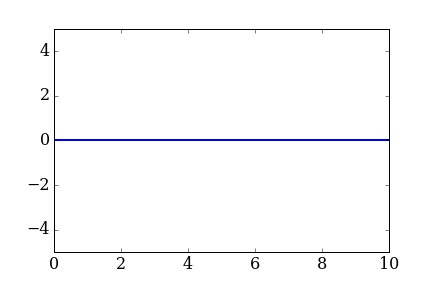
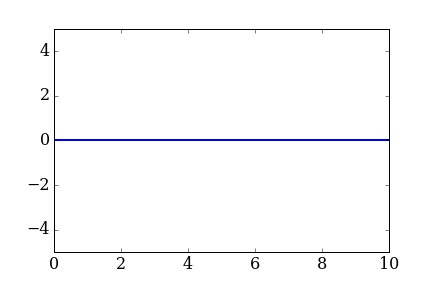
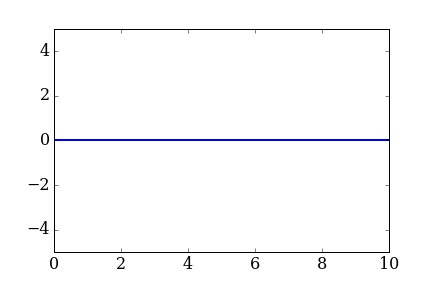
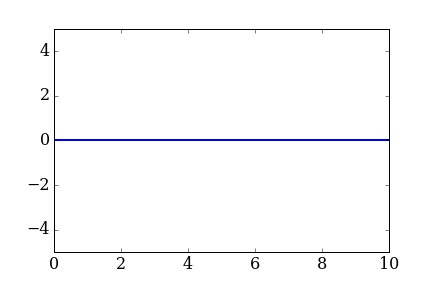
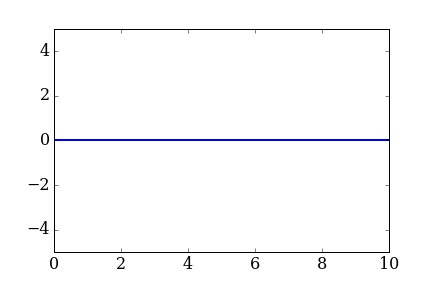
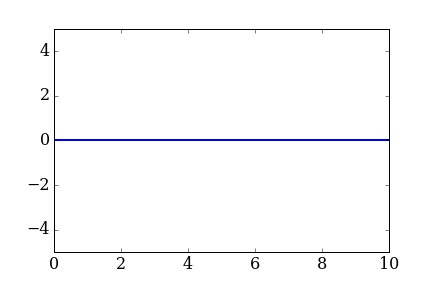
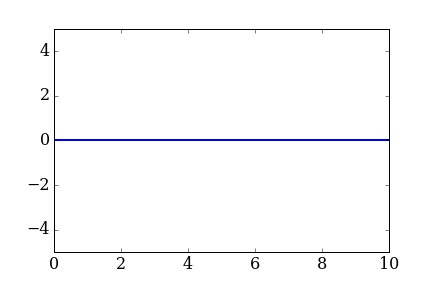
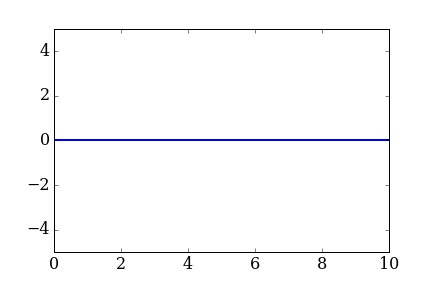
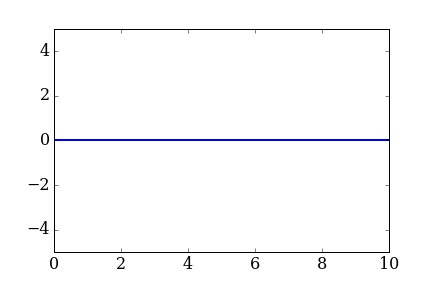
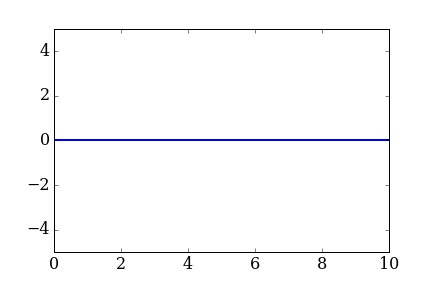
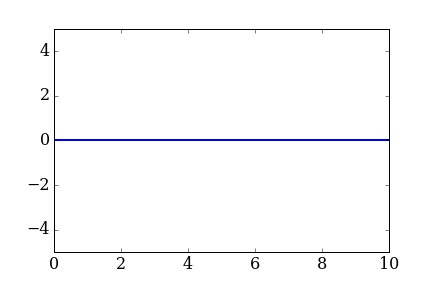
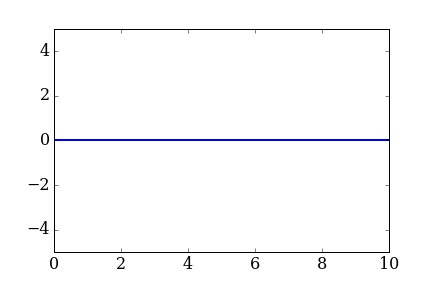
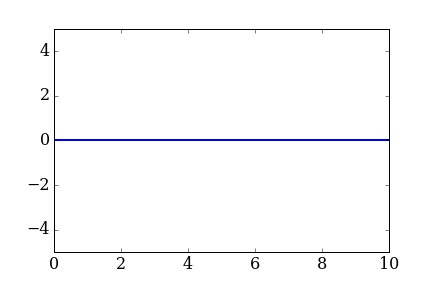
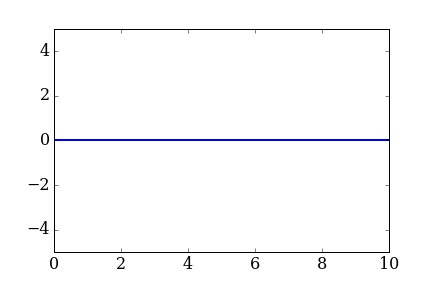
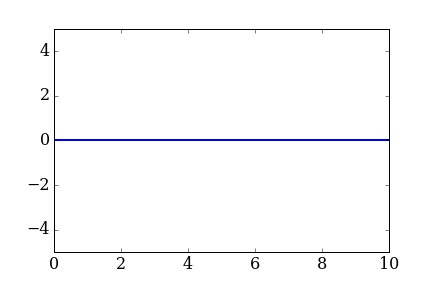
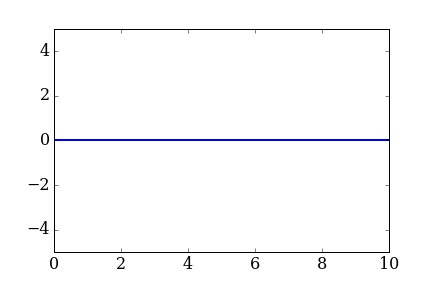
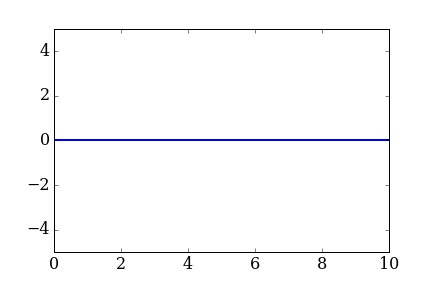
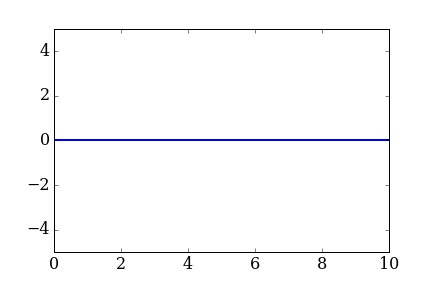
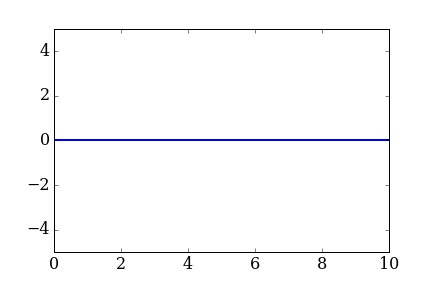
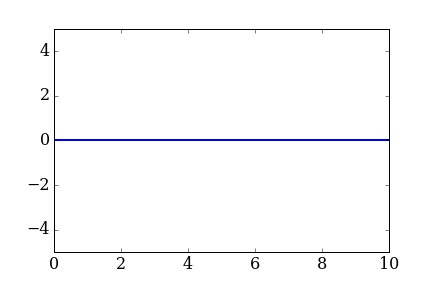
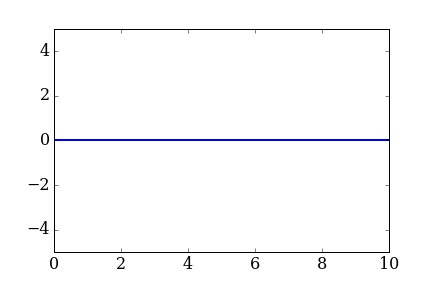
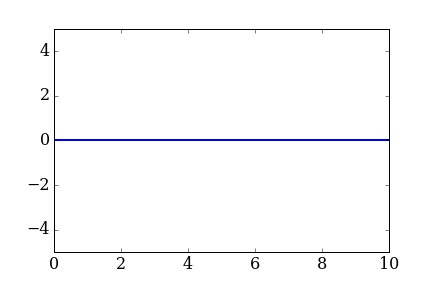
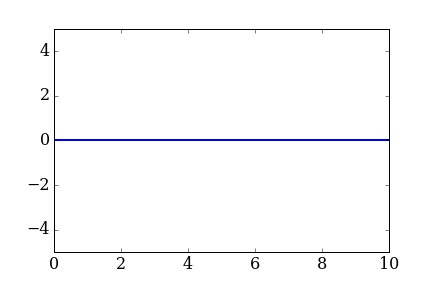
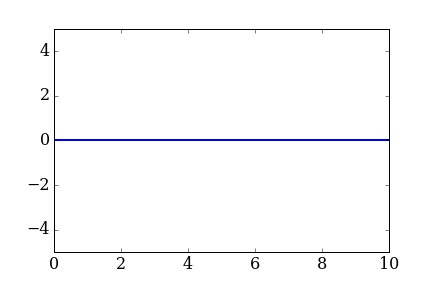
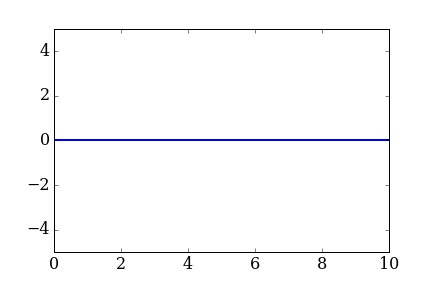
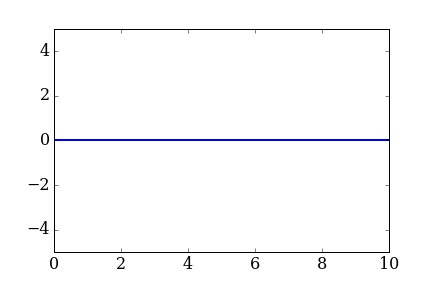
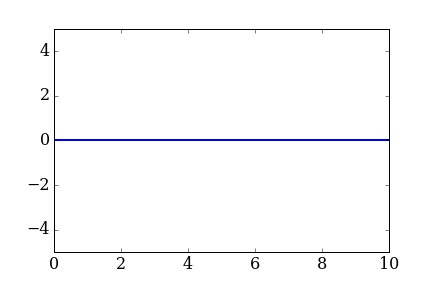
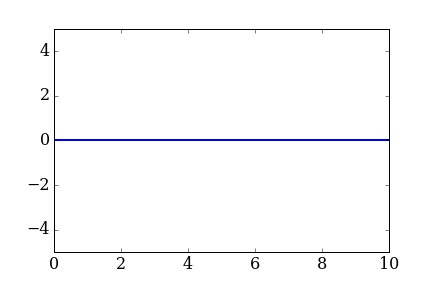
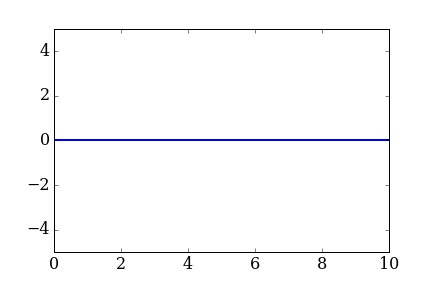
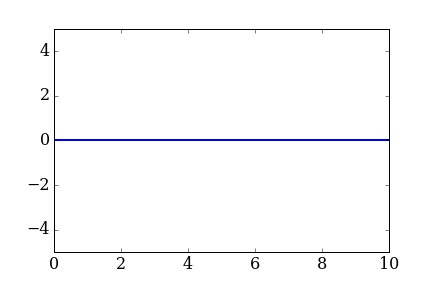
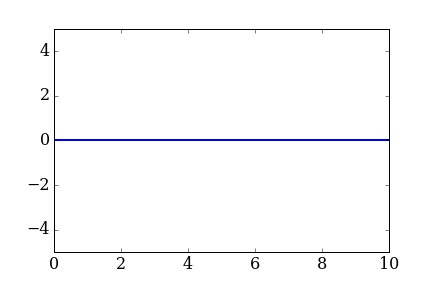
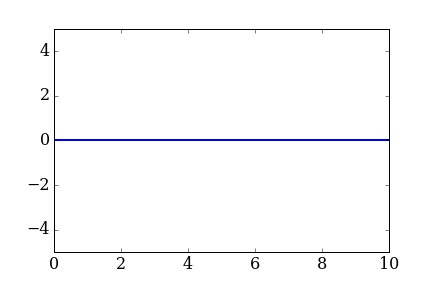
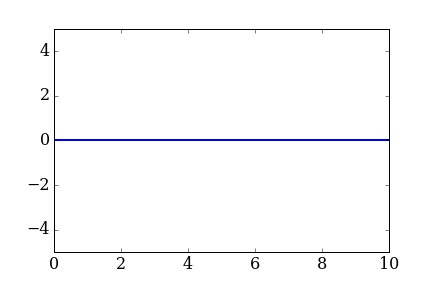
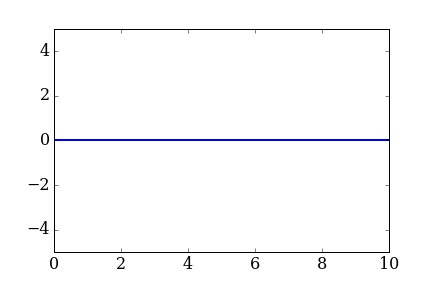
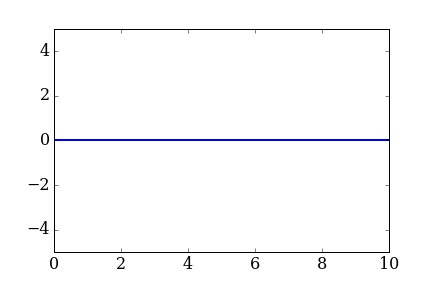
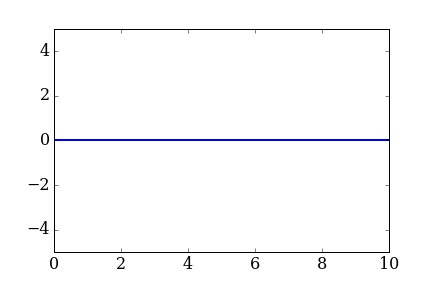
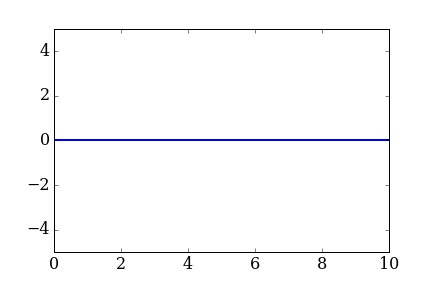
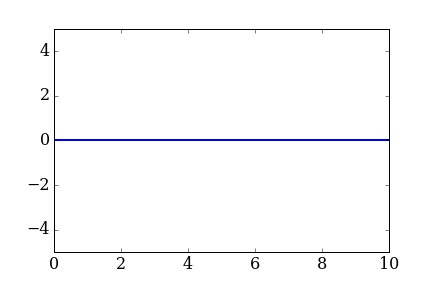
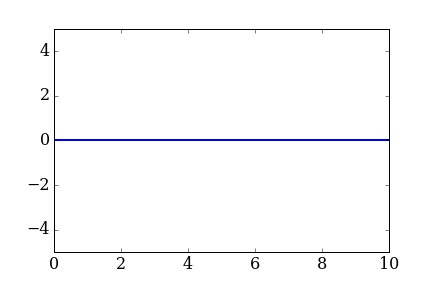
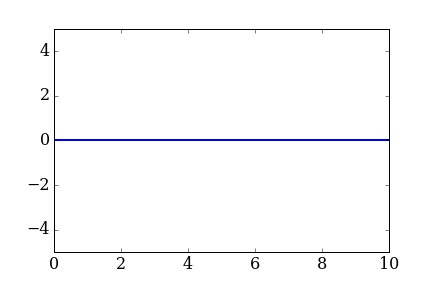
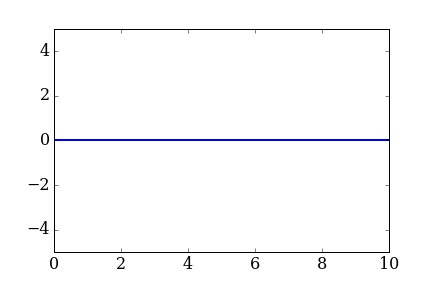
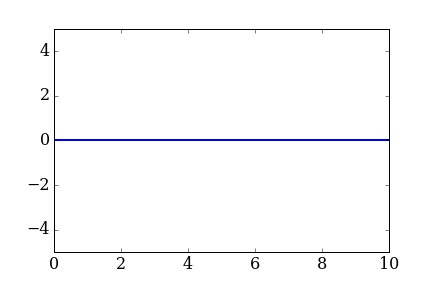
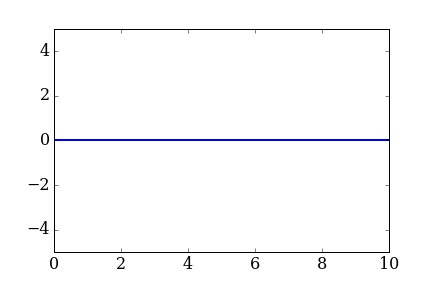
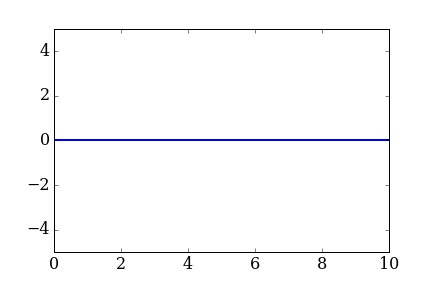
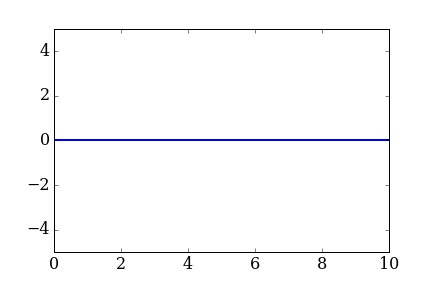
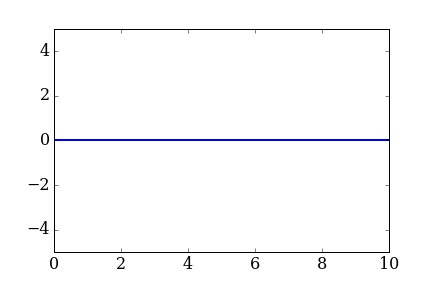
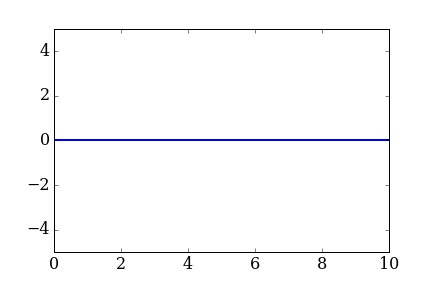
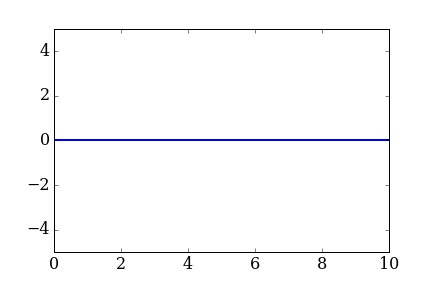
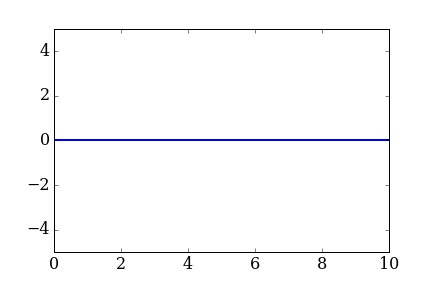
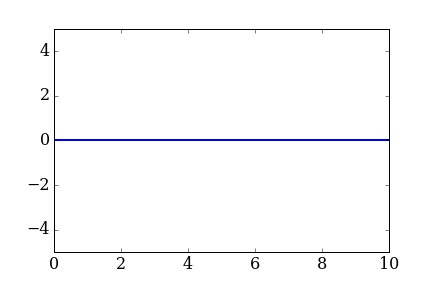
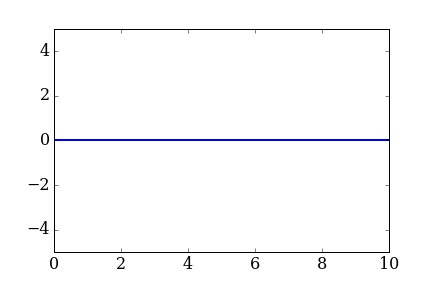
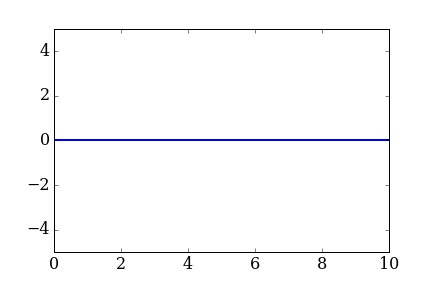
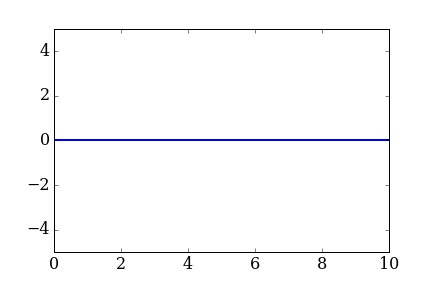
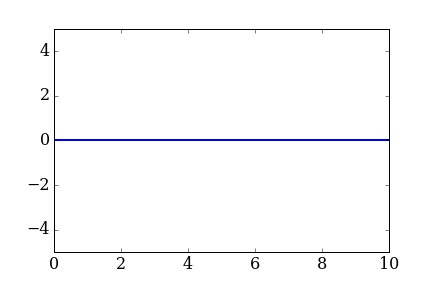
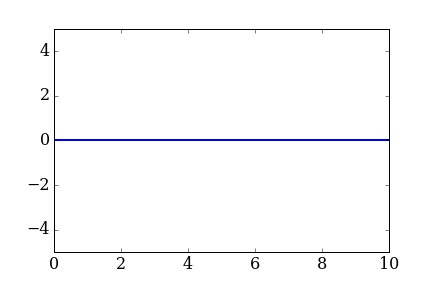
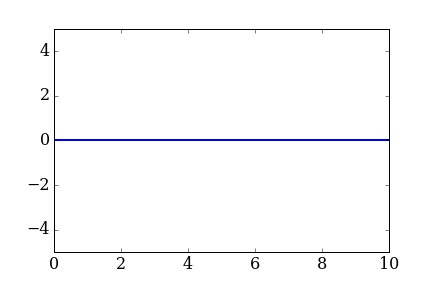
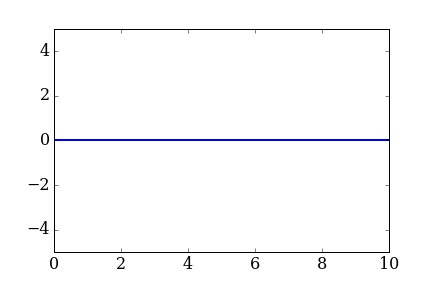
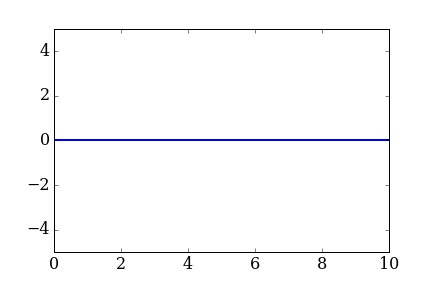
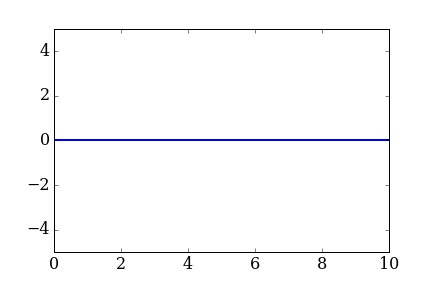
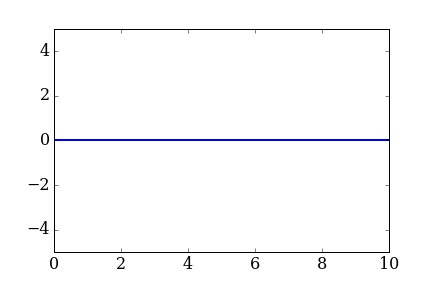
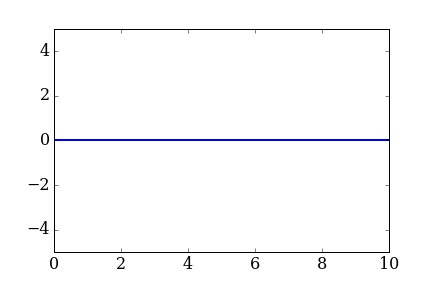
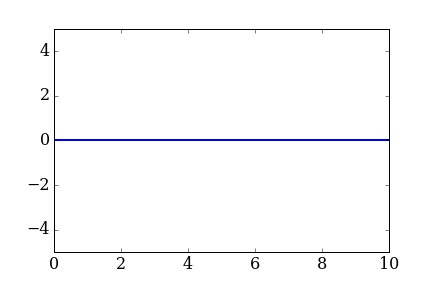
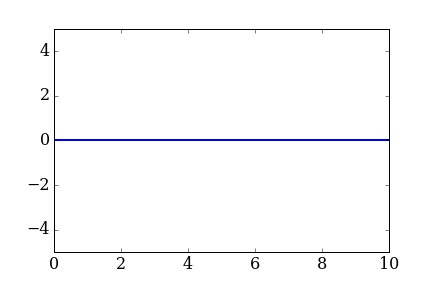
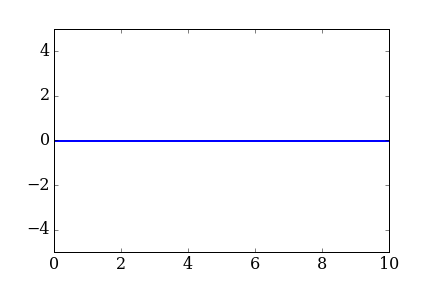
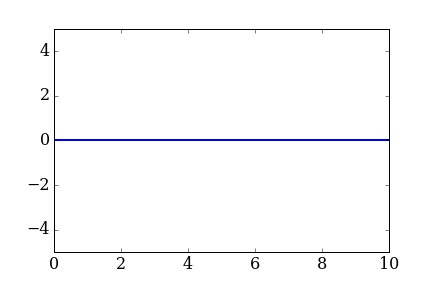
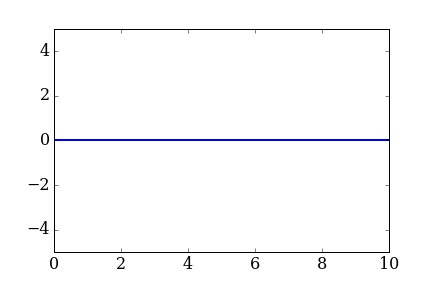
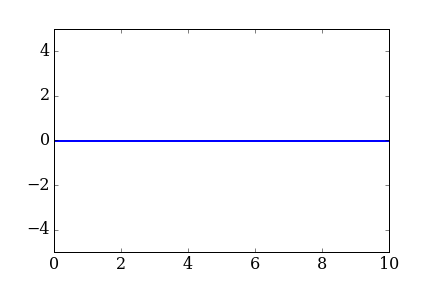
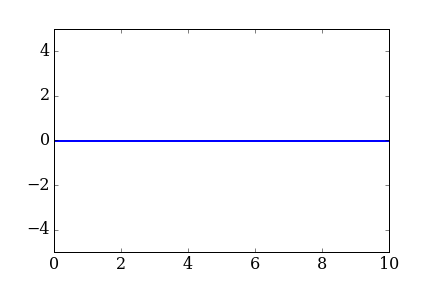
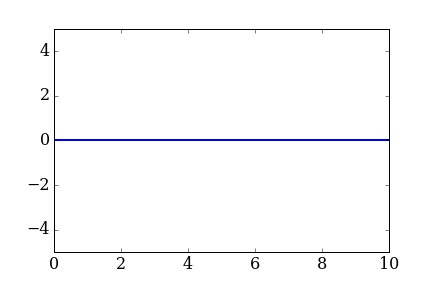
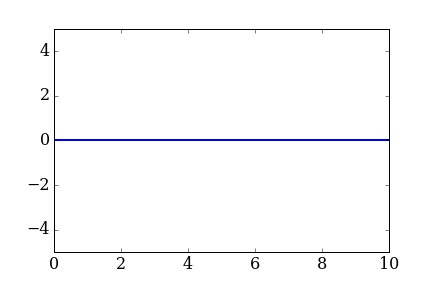
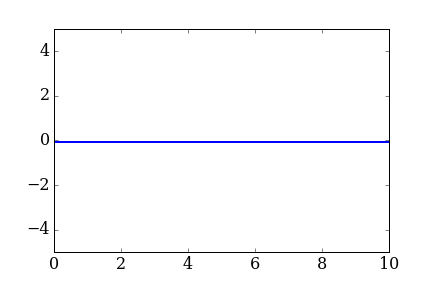
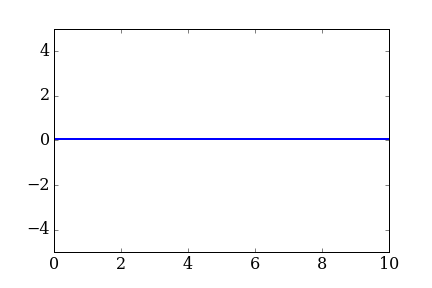
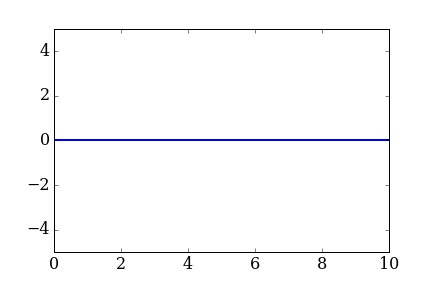
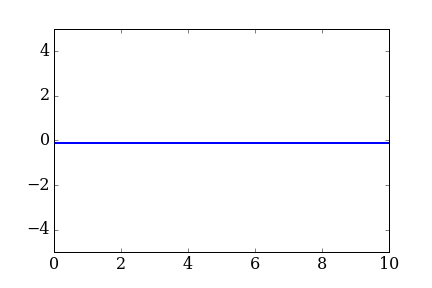
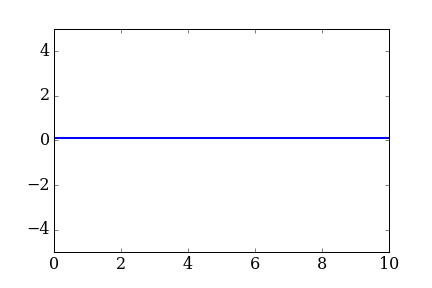
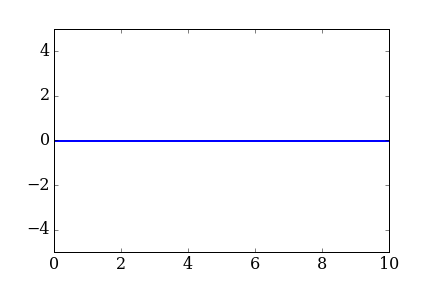
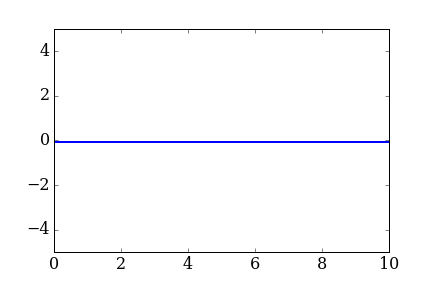
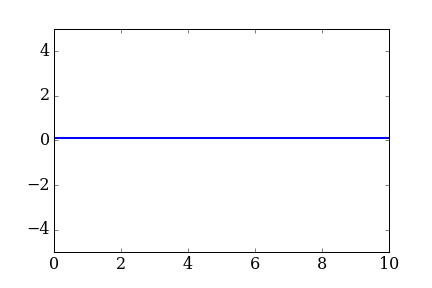
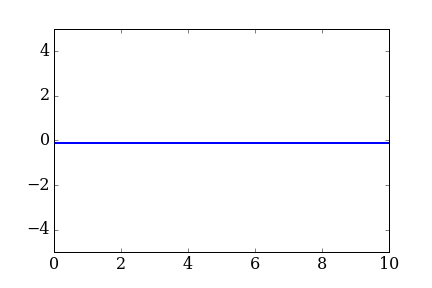
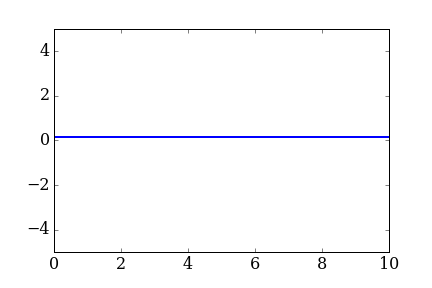
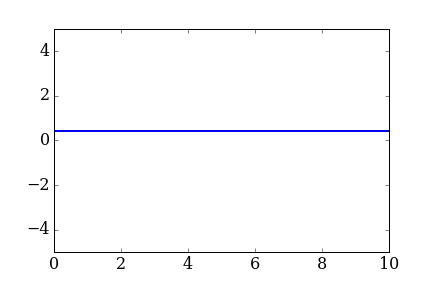
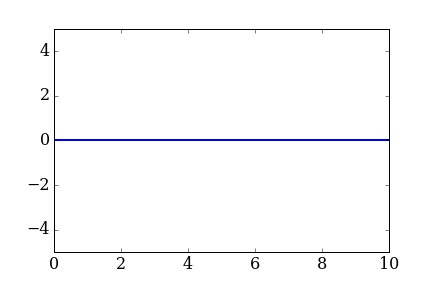

In [266]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

fig = pyplot.figure();
ax = pyplot.axes(xlim = (0,L), ylim = (-5,5))
line, = ax.plot([],[],lw = 2)

def animate(data):
    x = numpy.linspace(0, L, nx)
    y = data
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames = psi.real, interval = 50)

display_animation(anim, default_mode = 'once')

In [264]:
psi_conj = numpy.conj(psi)
probfunc = psi_conj*psi

#print(psi_conj)
#print()
print(probfunc)
probfunc_real = probfunc.real
#print(probfunc_real)

[  1.00000000e+00+0.j   1.68832272e-01+0.j   2.68316453e-02+0.j
   1.52829492e-02+0.j   1.22141341e-02+0.j   1.91836179e-02+0.j
   1.96722111e-02+0.j   1.69243505e-02+0.j   1.33559935e-02+0.j
   9.68712776e-03+0.j   6.48181521e-03+0.j   4.03545664e-03+0.j
   2.35403981e-03+0.j   1.29295965e-03+0.j   6.71211271e-04+0.j
   3.30415765e-04+0.j   1.54690826e-04+0.j   6.90604246e-05+0.j
   2.94729074e-05+0.j   1.20516274e-05+0.j   4.73200472e-06+0.j
   1.78783338e-06+0.j   6.51268752e-07+0.j   2.29181422e-07+0.j
   7.80522701e-08+0.j   2.57718539e-08+0.j   8.26403524e-09+0.j
   2.57763910e-09+0.j   7.83243553e-10+0.j   2.32189087e-10+0.j
   6.72429911e-11+0.j   1.90488017e-11+0.j   5.28475799e-12+0.j
   1.43750124e-12+0.j   3.83773400e-13+0.j   1.00659184e-13+0.j
   2.59623748e-14+0.j   6.59056071e-15+0.j   1.64792439e-15+0.j
   4.06177881e-16+0.j   9.87564811e-17+0.j   2.37011697e-17+0.j
   5.61829059e-18+0.j   1.31608618e-18+0.j   3.04935508e-19+0.j
   6.97979916e-20+0.j   1.59172653e-20+0

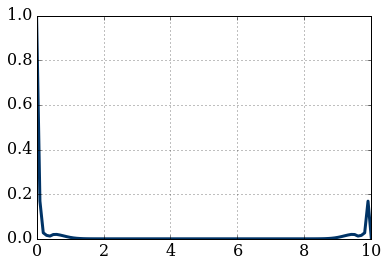

In [265]:
pyplot.plot(x, probfunc_real, color='#003366', ls='-', lw=3);
pyplot.grid(True)


In [84]:
def psi_analytical(x, t, n_max, h, m, L, hbar):
    
    psi = 0
    for n in range (1, n_max+1):
        
        E = ((n**2)*(h**2))/(8*m*(L**2))
        
        summation = numpy.sqrt(2/L)*numpy.sin(n*numpy.pi*x/L)*numpy.exp(-1j*E*t/hbar)
        psi+= summation
        
    return psi


In [85]:
psi_analytical = psi_analytical(x, dt*nt, 1, h, m, L, hbar)
print(psi_analytical)

print(psi_analytical.real)

[  0.00000000e+00 +0.00000000e+00j   8.87948794e-02 -8.76398789e-04j
   1.77239326e-01 -1.74933883e-03j   2.64984290e-01 -2.61537504e-03j
   3.51683482e-01 -3.47108955e-03j   4.36994740e-01 -4.31310525e-03j
   5.20581379e-01 -5.13809911e-03j   6.02113522e-01 -5.94281523e-03j
   6.81269397e-01 -6.72407777e-03j   7.57736614e-01 -7.47880345e-03j
   8.31213390e-01 -8.20401372e-03j   9.01409747e-01 -8.89684648e-03j
   9.68048651e-01 -9.55456746e-03j   1.03086711e+00 -1.01745809e-02j
   1.08961721e+00 -1.07544400e-02j   1.14406708e+00 -1.12918562e-02j
   1.19400185e+00 -1.17847085e-02j   1.23922443e+00 -1.22310521e-02j
   1.27955637e+00 -1.26291252e-02j   1.31483848e+00 -1.29773570e-02j
   1.34493152e+00 -1.32743730e-02j   1.36971673e+00 -1.35190012e-02j
   1.38909629e+00 -1.37102761e-02j   1.40299373e+00 -1.38474427e-02j
   1.41135419e+00 -1.39299599e-02j   1.41414468e+00 -1.39575018e-02j
   1.41135419e+00 -1.39299599e-02j   1.40299373e+00 -1.38474427e-02j
   1.38909629e+00 -1.37102761e-02j

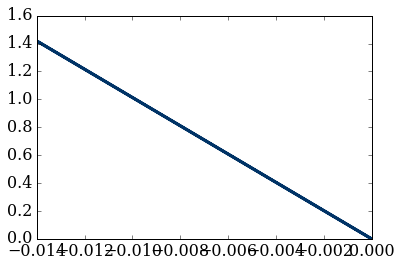

In [86]:
pyplot.plot(psi_analytical.imag, psi_analytical.real, color = '#003366', ls = '-', lw =3)

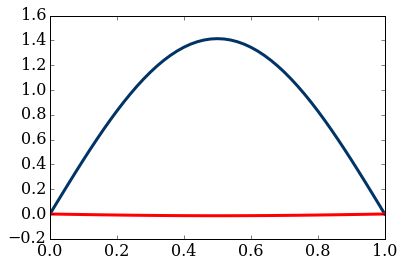

In [87]:
pyplot.plot(x, psi_analytical.real, color = '#003366', ls = '-', lw =3)
pyplot.plot(x, psi_analytical.imag, color = 'r', ls = '-', lw =3)

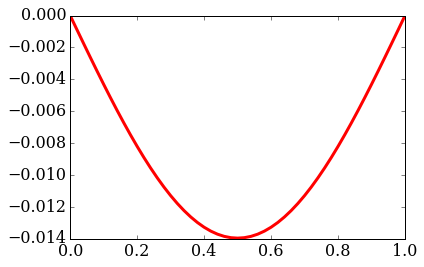

In [88]:
pyplot.plot(x, psi_analytical.imag, color = 'r', ls = '-', lw =3)

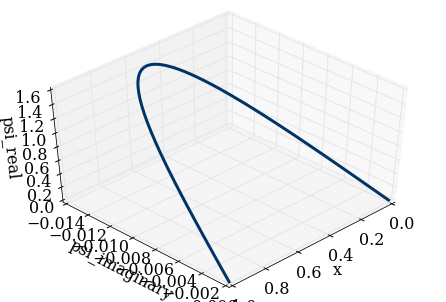

In [89]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.view_init(45,45)

ax.plot(x, psi_analytical.imag, psi_analytical.real, color = '#003366', lw =3)
ax.set_xlabel(r'x')
ax.set_ylabel(r'psi_imaginary')
ax.set_zlabel(r'psi_real')
#ax = pyplot.axes(xlabel=('x'),ylabel=('Real'), zlabel=('Imaginary'));#

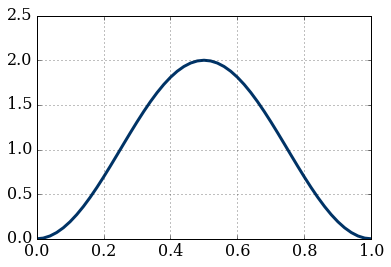

In [90]:
probfunc_analytical = numpy.conj(psi_analytical)*psi_analytical
pyplot.plot(x, probfunc_analytical.real, color='#003366', ls='-', lw=3);
pyplot.grid(True)

In [91]:
"""
fig = pylab.figure()
ax = Axes3D(fig)
ax.viewinit()

def animate(data):
    x = numpy.linspace(0, L, nx)
    y = data
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames = psi.real, interval = 50)

display_animation(anim, default_mode = 'once')
"""

"\nfig = pylab.figure()\nax = Axes3D(fig)\nax.viewinit()\n\ndef animate(data):\n    x = numpy.linspace(0, L, nx)\n    y = data\n    line.set_data(x, y)\n    return line,\n\nanim = animation.FuncAnimation(fig, animate, frames = psi.real, interval = 50)\n\ndisplay_animation(anim, default_mode = 'once')\n"